In [3]:
from pyjarowinkler import distance
from math import*
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.metrics import euclidean_distances
import gensim
import pymysql
import pymysql.cursors
from gensim import corpora, models
import math
from textblob import TextBlob as tb
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import requests
import json
import time
from sklearn.cluster import AgglomerativeClustering
import itertools

In [4]:
def connect_to_database():
    options = {
        'user': "root",
        'passwd': "root",
        'db': "KnowBase",
        'cursorclass' : pymysql.cursors.DictCursor
    }
    db = pymysql.connect(**options)
    db.autocommit(True)
    return db


# data clean, exclude stop word, need to to lower
def exclude_stop_word(bloblist):
    stop = set(stopwords.words('english'))
    filtered_words = [i for i in bloblist[0].lower().split() if i not in stop]
    return filtered_words


def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def attribute_overlap(m1, m2):
    att1 = m1["A"][0].split()
    object1 = ""
    if len(m1["A"]) > 1:
        object1 = m1["A"][1].split()
        att1.extend(object1)
    else:
        att1.append(object1)

    att2 = m2["A"][0].split()
    object2 = ""
    if len(m2["A"]) > 1:
        object2 = m2["A"][1].split()
        att2.extend(object2)
    else:
        att2.append(object2)

    return jaccard_similarity(att1, att2)


def string_similarity(m1, m2):
    entity1 = m1["n"]
    entity2 = m2["n"]
    str1 = " ".join(entity1)
    str2 = " ".join(entity2)
    return distance.get_jaro_distance(str1, str2, winkler=True, scaling=0.1)


def string_identity(m1, m2):
    entity1 = m1["n"]
    entity2 = m2["n"]
    str1 = " ".join(entity1)
    str2 = " ".join(entity2)
    if str1 == str2:
        return 1
    else:
        return 0

In [5]:
def precision(result, y):
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    newDict = {}
    toBeAdded = {}
    takenRate = {}
    indexAdd = len(trueDict)
    i = 0
    for key in groupDict.keys():
        listG = groupDict[key]
        sizeG = len(listG)
        maxRate = 0
        maxKey = 0
        if sizeG >= 3:
            for key2 in trueDict.keys():
                correct_count = 0
                listT = trueDict[key2]
                sizeT = len(listT)
                for item in listG:
                    if item in listT:
                        correct_count += 1
                rate = correct_count / sizeG
                if rate > maxRate:
                    maxRate = rate
                    maxKey = key2
            ## if three item all in same 4 item list
            if maxRate > 0.7: 
                if maxKey not in takenRate:
                    newDict[maxKey] = groupDict[key]
                    takenRate[maxKey] = [maxRate, key]
                else:
                    if maxRate > takenRate[maxKey][0]:
                        idx = takenRate[maxKey][1]
                        newDict[indexAdd] = groupDict[idx]
                        print("original key with this maxKey: " + str(idx))
                        newDict[maxKey] = groupDict[key]
                        takenRate[maxKey] = [maxRate, key]
                        indexAdd += 1
                        print("maxRate: " + str(maxRate) + " maxkey: " + str(maxKey) + " current key: " + str(key))
                    else:
                        newDict[indexAdd] = groupDict[key]
                        indexAdd += 1
            else:
                newDict[indexAdd] = groupDict[key]
                indexAdd += 1
                        
        else:
            newDict[indexAdd] = groupDict[key]
            indexAdd += 1


    inverseNew = {}
    for key in newDict.keys():
        for item in newDict[key]:
            inverseNew[item] = key
            

    total = 0
    j = 0
    while j < len(entity):
        if j not in inverseNew:
            j += 1
            continue
        if inverseNew[j] == inverseTrue[j]:
            total += 1
        j = j + 1
    return total / len(entity)

In [6]:
def macro_precision(result, y, n_cluster):
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalNotSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        f_id = -1
        i = 0
        control = True
        while i < len(temp) and control == True:
            f_id_cur = inverseTrue[temp[i]]
            if f_id == -1:
                f_id = f_id_cur
            else:
                if f_id_cur != f_id:
                    totalNotSame += 1
                    control = False
            i += 1
                    
    return (n_cluster-totalNotSame) / n_cluster

def macro_recall(result, y, n_cluster):
    return macro_precision(y, result, n_cluster)
    

def micro_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        output = {}
        maxO = 0
        maxKey = ""
        for item in temp:
            f_id = inverseTrue[item]
            if f_id not in output:
                output[f_id] = 1
            else:
                output[f_id] += 1
            
            if output[f_id] > maxO:
                maxO = output[f_id]
                maxKey = key
                
        totalSame += maxO
    return  totalSame / lenC
                
def micro_recall(result, y):
    return micro_precision(y, result)


def pairwise_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseTrue[temp[i]]
                f_id_j = inverseTrue[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair


def pairwise_recall(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseGroup = {}
    for key in groupDict.keys():
        for item in groupDict[key]:
            inverseGroup[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in trueDict.keys():
        temp = trueDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseGroup[temp[i]]
                f_id_j = inverseGroup[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair

In [7]:
def applyHAC(n_cluster_in, affinity_in, linkage_in, y):
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity=affinity_in, linkage=linkage_in)
    model.fit(entity_input)
    result = model.labels_
    return result

def apply_attribute_similarity(wordList, y, n_cluster_in):
    out = []
    for item1 in wordList:
        temp = []
        for item2 in wordList:
            result = np.exp(-attribute_overlap(item1, item2))
            temp.append(result)
        out.append(temp)
        
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(out)
    result = model.labels_
    Out_to_print = {}
    '''
    Out_to_print["micro precision"] = micro_precision(result, y)
    Out_to_print["micro recall"] = micro_recall(result, y)
    Out_to_print["macro precision"] = macro_precision(result, y, n_cluster_in)
    Out_to_print["macro recall"] = macro_recall(result, y, n_cluster_in)
    Out_to_print["pairwise precision"] = pairwise_precision(result, y)
    Out_to_print["pairwise recall"] = pairwise_recall(result, y)
    '''
    return result

def apply_string_identity(wordList, y, n_cluster_in):
    out = []
    for item1 in wordList:
        temp = []
        for item2 in wordList:
            result = np.exp(-string_identity(item1, item2))
            temp.append(result)
        out.append(temp)
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(out)
    result = model.labels_
    Out_to_print = {}
    '''
    Out_to_print["micro precision"] = micro_precision(result, y)
    Out_to_print["micro recall"] = micro_recall(result, y)
    Out_to_print["macro precision"] = macro_precision(result, y, n_cluster_in)
    Out_to_print["macro recall"] = macro_recall(result, y, n_cluster_in)
    Out_to_print["pairwise precision"] = pairwise_precision(result, y)
    Out_to_print["pairwise recall"] = pairwise_recall(result, y)
    '''
    return result

def apply_string_similarity(wordList, y, n_cluster_in):
    out = []
    for item1 in wordList:
        temp = []
        for item2 in wordList:
            result = string_similarity(item1, item2)
            if result < 0.8:
                result = 0
            result = np.exp(-result)
            temp.append(result)
        out.append(temp)
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(out)
    result = model.labels_
    '''
    Out_to_print = {}
    Out_to_print["micro precision"] = micro_precision(result, y)
    Out_to_print["micro recall"] = micro_recall(result, y)
    Out_to_print["macro precision"] = macro_precision(result, y, n_cluster_in)
    Out_to_print["macro recall"] = macro_recall(result, y, n_cluster_in)
    Out_to_print["pairwise precision"] = pairwise_precision(result, y)
    Out_to_print["pairwise recall"] = pairwise_recall(result, y)
    '''
    return result

In [9]:
db = connect_to_database()
cur = db.cursor()
string = "select b.freebase_id, b.entity, b.relation, b.value, b.link_am_score, b.link_scroe, b.base_id, "
string += "b.freebase_entity from NoiseEntity b"
cur.execute(string)
results = cur.fetchall()
groundTrue = {}
label = []
entity = []
entityDict = {}
y = []
i= 0
wordList = []
file_t = open("data.txt", 'w')
for result in results:
    string = result["base_id"] + ',' + result["entity"] + ',' + result["relation"] + ',' + result["value"] + ',' + result['freebase_id']
    string += "," + result["freebase_entity"] + ',' + result["link_scroe"] + ',' + result["link_am_score"] +'\n'
    file_t.write(string)
    ## create groundTrue Dictionary
    if result["freebase_id"] not in groundTrue:
        groundTrue[result["freebase_id"]] = i
        label.append(result["freebase_entity"].lower())
        i = i + 1
    if result["entity"] not in entityDict:
        entityDict[result["entity"].lower()] = 1
    entity.append(result["entity"].lower())
    y.append(groundTrue[result["freebase_id"]])
    
    temp = {}
    temp["n"] = result["entity"].lower().split()
    list_A = result["relation"].lower().split()
    list_A.extend(result["value"].lower().split())
    temp["A"] = list_A
    temp["f_id"] = result["freebase_id"]
    temp["f_entity"] = result["freebase_entity"]
    temp["score"] = result["link_scroe"]
    temp["am_score"] = result["link_am_score"]
    temp["relation"] = result["relation"]
    temp["value"] = result["value"]
    temp["id"] = result["base_id"]
    wordList.append(temp)

In [102]:
#print(apply_string_similarity(wordList, y, n_cluster))
#print(apply_attribute_similarity(wordList, y, n_cluster))
#print(apply_string_identity(wordList, y, n_cluster))

In [ ]:
## micro precision
micro_pre1 = []
micro_pre2 = []
micro_pre3 = []
## macro precision
macro_pre1 = []
macro_pre2 = []
macro_pre3 = []
## micro recall
micro_re1 = []
micro_re2 = []
micro_re3 = []
## macro recall
macro_re1 = []
macro_re2 = []
macro_re3 = []
## pairwise precision
pairwise_pre1 = []
pairwise_pre2 = []
pairwise_pre3 = []
## pairwise recall
pairwise_re1 = []
pairwise_re2 = []
pairwise_re3 = []
n_cluster = 120
while n_cluster <= 150:
    print("start")
    result1 = apply_string_similarity(wordList, y, n_cluster)
    result2 = apply_attribute_similarity(wordList, y, n_cluster)
    result3 = apply_string_identity(wordList, y, n_cluster)
    ## micro
    micro_pre1.append(micro_precision(result1, y))
    micro_pre2.append(micro_precision(result2, y))
    micro_pre3.append(micro_precision(result3, y))
    micro_re1.append(micro_recall(result1, y))
    micro_re2.append(micro_recall(result2, y))
    micro_re3.append(micro_recall(result3, y))
    ## macro
    macro_pre1.append(macro_precision(result1, y, n_cluster))
    macro_pre2.append(macro_precision(result2, y, n_cluster))
    macro_pre3.append(macro_precision(result3, y, n_cluster))
    macro_re1.append(macro_recall(result1, y, n_cluster))
    macro_re2.append(macro_recall(result2, y, n_cluster))
    macro_re3.append(macro_recall(result3, y, n_cluster))
    ## pairwise
    pairwise_pre1.append(pairwise_precision(result1, y))
    pairwise_pre2.append(pairwise_precision(result2, y))
    pairwise_pre3.append(pairwise_precision(result3, y))
    pairwise_re1.append(pairwise_recall(result1, y))
    pairwise_re2.append(pairwise_recall(result2, y))
    pairwise_re3.append(pairwise_recall(result3, y))
    print("end one")
    n_cluster += 5

start


In [ ]:
c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,micro_pre1, label = "String Similarity Precision")
plt.plot(c,micro_re1, label = "String Similarity Recall")
plt.plot(c,micro_pre2, label = "Attribute Overlap Precision")
plt.plot(c,micro_re2, label = "Attribute Overlap Recall")
plt.plot(c,micro_pre3, label = "String Identity Precision")
plt.plot(c,micro_re3, label = "String Identity Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,macro_pre1, label = "String Similarity Precision")
plt.plot(c,macro_re1, label = "String Similarity Recall")
plt.plot(c,macro_pre2, label = "Attribute Overlap Precision")
plt.plot(c,macro_re2, label = "Attribute Overlap Recall")
plt.plot(c,macro_pre3, label = "String Identity Precision")
plt.plot(c,macro_re3, label = "String Identity Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,pairwise_pre1, label = "String Similarity Precision")
plt.plot(c,pairwise_re1, label = "String Similarity Recall")
plt.plot(c,pairwise_pre2, label = "Attribute Overlap Precision")
plt.plot(c,pairwise_re2, label = "Attribute Overlap Recall")
plt.plot(c,pairwise_pre3, label = "String Identity Precision")
plt.plot(c,pairwise_re3, label = "String Identity Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [77]:
bagList = []
bagDict = {}
i = 0
for key in entityDict.keys():
    for item in key.split():
        if item not in bagDict:
            bagList.append(item.lower())
            bagDict[item.lower()] = i
            i = i + 1
            
entity_input = []
temp = [0 for x in range(i)]

for word in entity:
    temp = [0 for x in range(i)]
    for item in word.split():
        index = bagDict[item.lower()]
        temp[index] = 1
    entity_input.append(temp) 

In [83]:
n_cluster = 150
result1 = applyHAC(n_cluster, "euclidean", "average", y)
result2 = applyHAC(n_cluster, "cosine", "average", y)
result3 = applyHAC(n_cluster, "euclidean", "ward", y)
result4 = applyHAC(n_cluster, "euclidean", "complete", y)
result5 = applyHAC(n_cluster, "cosine", "complete", y)
str1 = "micro_precision: " + str(micro_precision(result1, y)) + " micro_recall: " + str(micro_recall(result1,y)) 
str11 = "pair_wise: " + str(pairwise_precision(result1, y)) + " pairwise_recall: " + str(pairwise_recall(result1, y))
str111 = "macro_precision: " + str(macro_precision(result1, y, 150)) + " macro_call: " + str(macro_recall(result1, y, 150))
print(1)
print(str1)
print(str111)
print(str11)
str2 = "micro_precision: " + str(micro_precision(result2, y)) + " micro_recall: " + str(micro_recall(result2,y))
str22 = "pair_wise: " + str(pairwise_precision(result2, y)) + " pairwise_recall: " + str(pairwise_recall(result2, y))
str222 = "macro_precision: " + str(macro_precision(result2, y, 150)) + " macro_call: " + str(macro_recall(result2, y, 150))
print(2)
print(str2)
print(str222)
print(str22)
str3 = "precision: " + str(micro_precision(result3, y)) + " micro_recall: " + str(micro_recall(result3,y)) 
str33 = "pair_wise: " + str(pairwise_precision(result3, y)) + " pairwise_recall: " + str(pairwise_recall(result3, y))
str333 = "macro_precision: " + str(macro_precision(result3, y, 150)) + " macro_call: " + str(macro_recall(result3, y, 150))
print(3)
print(str3) 
print(str333)
print(str33)
str4 = "micro_precision: " + str(micro_precision(result4, y)) + " micro_recall: " + str(micro_recall(result4,y)) 
str44 = "pair_wise: " + str(pairwise_precision(result4, y)) + " pairwise_recall: " + str(pairwise_recall(result4, y))
str444 = "macro_precision: " + str(macro_precision(result4, y, 150)) + " macro_call: " + str(macro_recall(result4, y, 150))
print(4)
print(str4) 
print(str444)
print(str44)
str5 = "micro_precision: " + str(micro_precision(result5, y)) + " micro_recall: " + str(micro_recall(result5,y)) 
str55 = "pair_wise: " + str(pairwise_precision(result5, y)) + " pairwise_recall: " + str(pairwise_recall(result5, y))
str555 = "macro_precision: " + str(macro_precision(result5, y, 150)) + " macro_call: " + str(macro_recall(result5, y, 150))
print(5)
print(str5)
print(str555)
print(str55)

1
micro_precision: 0.9459381324082105 micro_recall: 0.9855449551893611
macro_precision: 0.9866666666666667 macro_call: 0.9466666666666667
pair_wise: 0.9692107545533392 pairwise_recall: 0.9395779126915293
2
micro_precision: 0.981786643538595 micro_recall: 0.9855449551893611
macro_precision: 0.96 macro_call: 0.9533333333333334
pair_wise: 0.9692107545533392 pairwise_recall: 0.969933506793871
3
precision: 0.9846776525007227 micro_recall: 0.9463717837525296
macro_precision: 0.98 macro_call: 0.8866666666666667
pair_wise: 0.9008383925990171 pairwise_recall: 0.9845331020526163
4
micro_precision: 0.9434807747904018 micro_recall: 0.9540329575021682
macro_precision: 0.9866666666666667 macro_call: 0.86
pair_wise: 0.9090777681410812 pairwise_recall: 0.9277247759468055
5
micro_precision: 0.973258167100318 micro_recall: 0.9595258745302111
macro_precision: 0.9533333333333334 macro_call: 0.88
pair_wise: 0.9151488869615496 pairwise_recall: 0.9572130673605088


In [89]:
## micro precision
micro_pre1 = []
micro_pre2 = []
micro_pre3 = []
micro_pre4 = []
micro_pre5 = []
## macro precision
macro_pre1 = []
macro_pre2 = []
macro_pre3 = []
macro_pre4 = []
macro_pre5 = []
## micro recall
micro_re1 = []
micro_re2 = []
micro_re3 = []
micro_re4 = []
micro_re5 = []
## macro recall
macro_re1 = []
macro_re2 = []
macro_re3 = []
macro_re4 = []
macro_re5 = []
## pairwise precision
pairwise_pre1 = []
pairwise_pre2 = []
pairwise_pre3 = []
pairwise_pre4 = []
pairwise_pre5 = []
## pairwise recall
pairwise_re1 = []
pairwise_re2 = []
pairwise_re3 = []
pairwise_re4 = []
pairwise_re5 = []
n_cluster = 120
while n_cluster <= 150:
    result1 = applyHAC(n_cluster, "euclidean", "average", y)
    result2 = applyHAC(n_cluster, "cosine", "average", y)
    result3 = applyHAC(n_cluster, "euclidean", "ward", y)
    result4 = applyHAC(n_cluster, "euclidean", "complete", y)
    result5 = applyHAC(n_cluster, "cosine", "complete", y)
    ## micro
    micro_pre1.append(micro_precision(result1, y))
    micro_pre2.append(micro_precision(result2, y))
    micro_pre3.append(micro_precision(result3, y))
    micro_pre4.append(micro_precision(result4, y))
    micro_pre5.append(micro_precision(result5, y))
    micro_re1.append(micro_recall(result1, y))
    micro_re2.append(micro_recall(result2, y))
    micro_re3.append(micro_recall(result3, y))
    micro_re4.append(micro_recall(result4, y))
    micro_re5.append(micro_recall(result5, y))
    ## macro
    macro_pre1.append(macro_precision(result1, y, n_cluster))
    macro_pre2.append(macro_precision(result2, y, n_cluster))
    macro_pre3.append(macro_precision(result3, y, n_cluster))
    macro_pre4.append(macro_precision(result4, y, n_cluster))
    macro_pre5.append(macro_precision(result5, y, n_cluster))
    macro_re1.append(macro_recall(result1, y, n_cluster))
    macro_re2.append(macro_recall(result2, y, n_cluster))
    macro_re3.append(macro_recall(result3, y, n_cluster))
    macro_re4.append(macro_recall(result4, y, n_cluster))
    macro_re5.append(macro_recall(result5, y, n_cluster))
    ## pairwise
    pairwise_pre1.append(pairwise_precision(result1, y))
    pairwise_pre2.append(pairwise_precision(result2, y))
    pairwise_pre3.append(pairwise_precision(result3, y))
    pairwise_pre4.append(pairwise_precision(result4, y))
    pairwise_pre5.append(pairwise_precision(result5, y))
    pairwise_re1.append(pairwise_recall(result1, y))
    pairwise_re2.append(pairwise_recall(result2, y))
    pairwise_re3.append(pairwise_recall(result3, y))
    pairwise_re4.append(pairwise_recall(result4, y))
    pairwise_re5.append(pairwise_recall(result5, y))
    print("end one")
    n_cluster += 5

end one
end one
end one
end one
end one
end one
end one


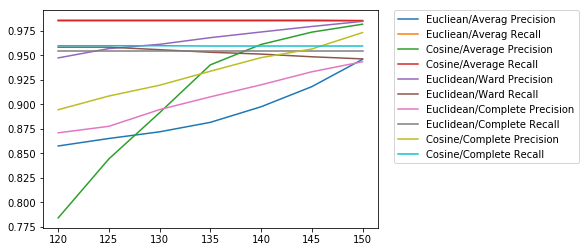

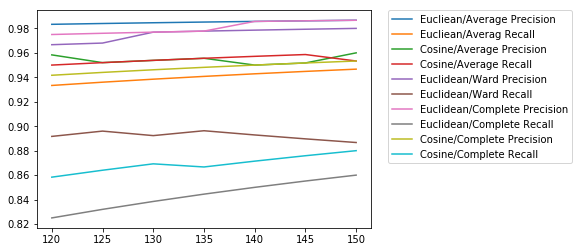

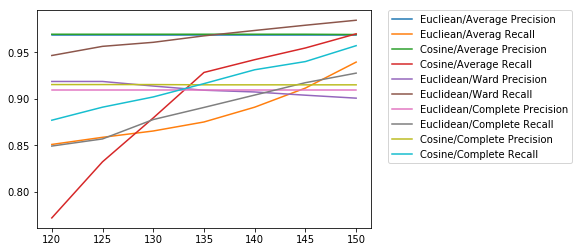

In [92]:
c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,micro_pre1, label = "Eucliean/Averag Precision")
plt.plot(c,micro_re1, label = "Eucliean/Averag Recall")
plt.plot(c,micro_pre2, label = "Cosine/Average Precision")
plt.plot(c,micro_re2, label = "Cosine/Average Recall")
plt.plot(c,micro_pre3, label = "Euclidean/Ward Precision")
plt.plot(c,micro_re3, label = "Euclidean/Ward Recall")
plt.plot(c,micro_pre4, label = "Euclidean/Complete Precision")
plt.plot(c,micro_re4, label = "Euclidean/Complete Recall")
plt.plot(c,micro_pre5, label = "Cosine/Complete Precision")
plt.plot(c,micro_re5, label = "Cosine/Complete Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,macro_pre1, label = "Eucliean/Average Precision")
plt.plot(c,macro_re1, label = "Eucliean/Averag Recall")
plt.plot(c,macro_pre2, label = "Cosine/Average Precision")
plt.plot(c,macro_re2, label = "Cosine/Average Recall")
plt.plot(c,macro_pre3, label = "Euclidean/Ward Precision")
plt.plot(c,macro_re3, label = "Euclidean/Ward Recall")
plt.plot(c,macro_pre4, label = "Euclidean/Complete Precision")
plt.plot(c,macro_re4, label = "Euclidean/Complete Recall")
plt.plot(c,macro_pre5, label = "Cosine/Complete Precision")
plt.plot(c,macro_re5, label = "Cosine/Complete Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150]
plt.plot(c,pairwise_pre1, label = "Eucliean/Average Precision")
plt.plot(c,pairwise_re1, label = "Eucliean/Averag Recall")
plt.plot(c,pairwise_pre2, label = "Cosine/Average Precision")
plt.plot(c,pairwise_re2, label = "Cosine/Average Recall")
plt.plot(c,pairwise_pre3, label = "Euclidean/Ward Precision")
plt.plot(c,pairwise_re3, label = "Euclidean/Ward Recall")
plt.plot(c,pairwise_pre4, label = "Euclidean/Complete Precision")
plt.plot(c,pairwise_re4, label = "Euclidean/Complete Recall")
plt.plot(c,pairwise_pre5, label = "Cosine/Complete Precision")
plt.plot(c,pairwise_re5, label = "Cosine/Complete Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()